# MNIST: convolutional neural networks

We define and train a convolutional neural network (CNN) model to recognize handwritten digits.  Although CNNs can be used in many contexts, they are probably most often used in the context of image processing.

## Required imports

In [1]:
import keras
from keras import backend as K
from keras.datasets import mnist
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Data preparation

Depending on the backend keras uses, the input format slightly differs. Either the number of color channels is the first, or the last dimension.  Our input data is grayscale, so there is only a single color channel

In [2]:
img_channels, img_rows, img_cols = 1, 28, 28

if K.image_data_format() == 'channels_first':
    shape_ord = (img_channels, img_rows, img_cols)
else:  # channel_last
    shape_ord = (img_rows, img_cols, img_channels)

Load the data again.

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

### Data preprocessing

First, reshape the input data to take into account the color channels of the images.

In [4]:
x_train = x_train.reshape((x_train.shape[0],) + shape_ord)
x_test = x_test.reshape((x_test.shape[0],) + shape_ord)

Most learning algorithms work better when the input data is normalized to the interval $[0, 1]$.

In [5]:
x_train = x_train.astype(np.float32)/255.0
x_test = x_test.astype(np.float32)/255.0

The output can be transformed to categorical data, i.e., one category for each digit, rather than a `uint8`. This is a one-hot encoding, so the output is now an array consisting of a single 1.0 value, and nine 0.0 values.  Note that the type of the output is now also `float32`.

In [6]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

### Validation data

In order to make this reproducible, we have to seed the random number generator.

In [7]:
np.random.seed(1234)

During the training, we will require a validation set, so we split the training data into two sets, one for actual training, the other for validation.  Note, we don't touch the test data set at all during the training process.  The default is using 75 % of the data for training, 25 % for validation. This function will also shuffle the data set prior to splitting (hence seeding the random number generator).

In [8]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train)

In [9]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((45000, 28, 28, 1), (15000, 28, 28, 1), (45000, 10), (15000, 10))

### Verification

Since we've done quite some transformations, let's verify whether we didn't mess up.

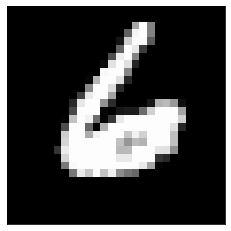

In [10]:
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
plt.imshow(x_train[0, :, :, 0], cmap='gray');

In [11]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

## Simple CNN

We start with a very straightforward network with a single convolutional layer.

### Required imports

In [12]:
from keras.models import Sequential
from keras.layers import Activation, Conv2D, Dense, Dropout, Flatten
from keras.optimizers import SGD

### Model defintion

The network has 32 filters, each 3 $\times$ 3 pixels in its convolutional layer, and a ReLU activation function. For the second, dense layer, the output of the convolutional layer is first flattened. The dense layer's activation function is SoftMax to determine the category for the image.

In [13]:
nr_filters = 32
nr_classes = 10
conv_x_size, conv_y_size = 3, 3
cnn_model = Sequential()
cnn_model.add(Conv2D(nr_filters, (conv_x_size, conv_y_size), padding='valid',
                     input_shape=shape_ord))
cnn_model.add(Activation('relu'))
cnn_model.add(Flatten())
cnn_model.add(Dense(nr_classes))
cnn_model.add(Activation('softmax'))

In [14]:
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 21632)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                216330    
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 216,650
Trainable params: 216,650
Non-trainable params: 0
_________________________________________________________________


In [15]:
cnn_hist = cnn_model.compile(loss='categorical_crossentropy',
                             optimizer=SGD(lr=0.1, decay=1.0e-6, 
                                           momentum=0.9, nesterov=True),
                             metrics=['accuracy'])

### Training

In [16]:
cnn_hist = cnn_model.fit(x_train, y_train, batch_size=32, epochs=10,
                         verbose=1, validation_data=(x_val, y_val))

Train on 45000 samples, validate on 15000 samples
Epoch 1/10
45000/45000 [==============================] - 19s 428us/step - loss: 0.2005 - acc: 0.9394 - val_loss: 0.1194 - val_acc: 0.9629
Epoch 2/10
45000/45000 [==============================] - 7s 151us/step - loss: 0.0982 - acc: 0.9708 - val_loss: 0.1194 - val_acc: 0.9651
Epoch 3/10
45000/45000 [==============================] - 7s 151us/step - loss: 0.0733 - acc: 0.9768 - val_loss: 0.1359 - val_acc: 0.9656
Epoch 4/10
45000/45000 [==============================] - 7s 149us/step - loss: 0.0611 - acc: 0.9812 - val_loss: 0.1492 - val_acc: 0.9612
Epoch 5/10
45000/45000 [==============================] - 7s 147us/step - loss: 0.0460 - acc: 0.9855 - val_loss: 0.1442 - val_acc: 0.9691
Epoch 6/10
45000/45000 [==============================] - 7s 150us/step - loss: 0.0356 - acc: 0.9885 - val_loss: 0.1513 - val_acc: 0.9699
Epoch 7/10
45000/45000 [==============================] - 7s 152us/step - loss: 0.0382 - acc: 0.9883 - val_loss: 0.1565 -

In [17]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')

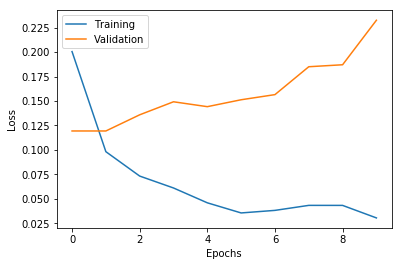

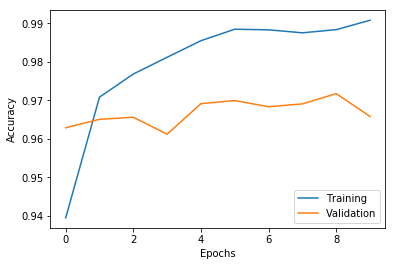

In [18]:
plot_history(cnn_hist)

In [19]:
cnn_model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 53us/step


[0.22718559999494864, 0.9696]

Although the test accuracy is quite acceptable, the training accuracy is a lot higher, so most likely there is some overfitting.

In [20]:
cnn_model.save('mnist_cnn.h5')

## More layers & dropout

This model has an additional hidden layer to improve accuracy.

In [21]:
nr_filters = 32
nr_classes = 10
conv_x_size, conv_y_size = 3, 3
cnn_do_model = Sequential()
cnn_do_model.add(Conv2D(nr_filters, (conv_x_size, conv_y_size), padding='valid',
                     input_shape=shape_ord))
cnn_do_model.add(Activation('relu'))
cnn_do_model.add(Flatten())
cnn_do_model.add(Dense(128))
cnn_do_model.add(Activation('relu'))
cnn_do_model.add(Dropout(0.1))
cnn_do_model.add(Dense(nr_classes))
cnn_do_model.add(Activation('softmax'))

In [22]:
cnn_do_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_3 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 21632)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               2769024   
_________________________________________________________________
activation_4 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
__________

In [23]:
cnn_do_model.compile(loss='categorical_crossentropy',
                     optimizer=SGD(),
                     metrics=['accuracy'])

In [24]:
cnn_do_hist = cnn_do_model.fit(x_train, y_train, batch_size=32, epochs=10,
                               verbose=1, validation_data=(x_val, y_val))

Train on 45000 samples, validate on 15000 samples
Epoch 1/10
45000/45000 [==============================] - 8s 180us/step - loss: 0.4426 - acc: 0.8789 - val_loss: 0.2868 - val_acc: 0.9103
Epoch 2/10
45000/45000 [==============================] - 8s 172us/step - loss: 0.2107 - acc: 0.9386 - val_loss: 0.1764 - val_acc: 0.9475
Epoch 3/10
45000/45000 [==============================] - 8s 174us/step - loss: 0.1626 - acc: 0.9525 - val_loss: 0.1373 - val_acc: 0.9586
Epoch 4/10
45000/45000 [==============================] - 8s 170us/step - loss: 0.1337 - acc: 0.9607 - val_loss: 0.1188 - val_acc: 0.9657
Epoch 5/10
45000/45000 [==============================] - 7s 167us/step - loss: 0.1173 - acc: 0.9652 - val_loss: 0.1274 - val_acc: 0.9621
Epoch 6/10
45000/45000 [==============================] - 8s 167us/step - loss: 0.1047 - acc: 0.9684 - val_loss: 0.1056 - val_acc: 0.9687
Epoch 7/10
45000/45000 [==============================] - 8s 169us/step - loss: 0.0949 - acc: 0.9705 - val_loss: 0.1016 - 

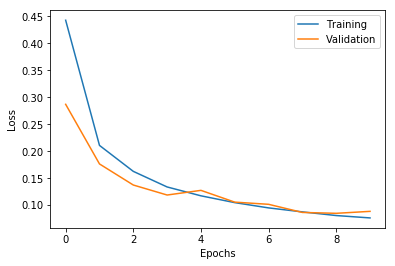

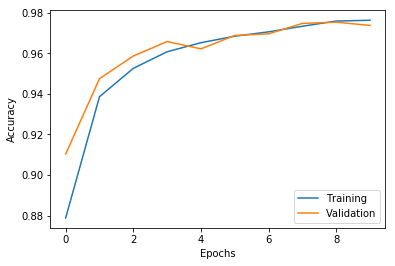

In [25]:
plot_history(cnn_do_hist)

In [26]:
cnn_do_model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 56us/step


[0.08391192257851363, 0.9762]

Now the accuracies for training, validation and test data are more in line.

In [27]:
cnn_do_model.save('mnist_cnn_do.h5')